In [88]:
import pandas as pd
import os; os.getcwd()
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [97]:
# Load pandas from zip
df = (
    pd.read_stata("data/full_panel.zip")
    )

# Drop if don't show up in all 3 waves
trajectories = (
    df
    .query("crop_code == 'MAIZE'")
    .dropna(subset= ['impmaize'])
    .groupby(['holder_id', 'parcel_id', 'field_id'])['impmaize']
    .agg(trajectories = list)
    .assign(len_traj = lambda df: df['trajectories'].apply(lambda x: len(x)))
    .query("len_traj == 3")
    .drop(['len_traj'], axis=1)
    )

# Merge back
balanced_panel_df = df.merge(trajectories, on = ['holder_id'])


/usr/lib/python3.9/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


## Create Map of Households

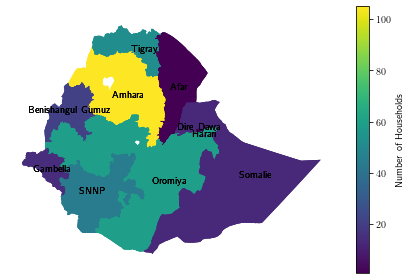

In [124]:
map = gpd.read_file("data/ethiopiaworeda/Eth_Woreda_2013.shp").replace({'REGIONNAME' : {'Beneshangul Gumu' : 'Benishangul Gumuz',
                                                                                       'Hareri' : 'Harari',
                                                                                       'SNNPR' : 'SNNP',
                                                                                       'Oromia' : 'Oromiya',
                                                                                       'Somali' : 'Somalie',
                                                                                       'Gambela' : 'Gambella'}})

# Get number of households per region
hhids = balanced_panel_df.drop_duplicates(['holder_id', 'wave']).groupby(['region', 'wave'])['household_id'].count()

fig, ax = plt.subplots()

ax.set_axis_off()

with mpl.rc_context(rc={'text.usetex': True}):
    merged_map = (
        map
        .dissolve('REGIONNAME')
        .merge(hhids, 
               left_index=True, 
               right_on = ['region'])
        .reset_index('region')
    )
    
    merged_map.plot(column = 'household_id', 
                legend=True, 
                ax=ax, 
                legend_kwds={'label' : 'Number of Households'},
                missing_kwds={'color': 'lightgrey'})
    
    merged_map.apply(lambda x: ax.annotate(text=x['region'], xy=x.geometry.representative_point().coords[0], ha='center'), axis=1)


    plt.tight_layout()

    plt.savefig("results/figures/map_hhids.pdf", format='pdf', dpi=160)

## Create Summary Table

In [146]:
balanced_panel_df.groupby('holder_id').transform(lambda x: x.fillna({'LAT_DD_MOD' : 'bfill', 'LON_DD_MOD' : 'bfill'}))[["LAT_DD_MOD", "LON_DD_MOD"]]